# Hartree Fock 

In [1]:
from itertools import product
import time

from IPython.display import Latex

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

import numpy as np

from scipy.integrate import simpson
from scipy.linalg import eigh
from scipy.optimize import curve_fit

Eh = 27.211386 # Hartee energy: unit energy in eV

# "learning rate"
eta = 0.001

rgrid = np.linspace(0, 5, 1000)

# 2. Hydrogen

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

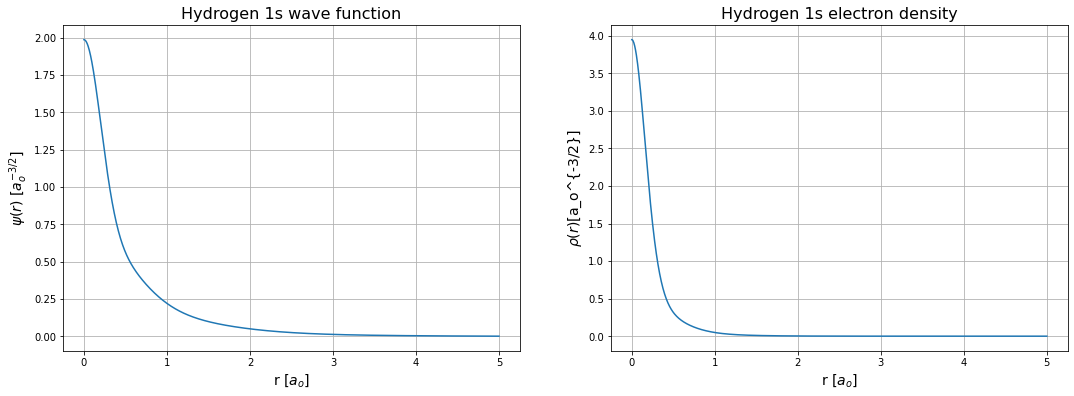

In [2]:
pdf = PdfPages('H.pdf')
Z = 1

alpha_H = [13.00773, 1.962079, 0.444529, 0.1219492]

def g_norm(*args):
    norm = 1
    for arg in args:
        norm *= (2 * alpha_H[arg] / np.pi)**(0.75)
    return norm

# kinetic and potential matrix
T = np.zeros((4, 4))
V = np.zeros((4, 4))

# overlap matrix
S = np.zeros((4, 4))

for p in range(4):
    for q in range(p+1):
        T[p, q] = 3 * np.pi**(1.5) * alpha_H[p] * alpha_H[q] 
        T[p, q] /= (alpha_H[p] + alpha_H[q])**(2.5)
        
        V[p, q] = -Z * 2 * np.pi / (alpha_H[p] + alpha_H[q])
        
        S[p, q] = (np.pi / (alpha_H[p] + alpha_H[q]))**(1.5)
    
H = T + V
# diagonalization for simmetric matrix
E, C = eigh(H, S)

# plot solution
wf_H = np.zeros(1000)
for q in range(4):
    wf_H += g_norm(q) * np.exp(-alpha_H[q] * rgrid**2) * C[q, 0]
    
wf_H = wf_H / np.sqrt(simpson(wf_H**2, rgrid))
C[:, 0] = C[:, 0] / np.sqrt(simpson(wf_H**2, rgrid))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Hydrogen 1s wave function', fontsize=16)
plt.plot(rgrid, -wf_H)
plt.grid()

display(Latex(f'$E_0$ = {np.real(E)[0]*Eh:.2f} eV'))
display(Latex(', '.join([f'$c_{{{i+1}}}$ = {-C[i, 0]:.8f}' for i in range(4)])))

plt.subplot(122)
plt.plot(rgrid, wf_H**2)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\rho(r) [$a_o^{-3/2}$]$', fontsize=14)
plt.title(f'Hydrogen 1s electron density', fontsize=16)
plt.grid()
pdf.savefig()
plt.show()

pdf.close()

# 3. Helium

In [3]:
alpha_He = [14.899983, 2.726485, 0.757447, 0.251390]

In [4]:
Z = 2

def g_norm(*args):
    norm = 1
    for arg in args:
        norm *= (2 * alpha_He[arg] / np.pi)**(0.75)
    return norm


# compute integral values beforehand
direct   = np.zeros((4,4,4,4))
exchange = np.zeros((4,4,4,4))
for p, q, r, s in product(range(4), repeat=4):
    alpha = alpha_He[p] + alpha_He[q]
    beta  = alpha_He[r] + alpha_He[s]

    direct[p, q, r, s] = g_norm(p, q, r, s) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)

    alpha = alpha_He[p] + alpha_He[s]
    beta  = alpha_He[q] + alpha_He[r]

    exchange[p, q, r, s] = g_norm(p, q, r, s) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)


h = np.zeros((4, 4))
S = np.zeros((4, 4))

for p, q in product(range(4), repeat=2):
    # h term
    h[p, q] = g_norm(p, q) * 3*np.pi**(1.5) * alpha_He[p] * alpha_He[q]
    h[p, q] /= (alpha_He[p] + alpha_He[q])**(2.5)
    h[p, q] -= g_norm(p, q) * Z * 2*np.pi / (alpha_He[p] + alpha_He[q])

    S[p, q] = g_norm(p, q) * (np.pi / (alpha_He[p] + alpha_He[q]))**(1.5)
        
e, C = eigh(h, S)

N = 10000

E = np.zeros((N, 2))
for n in range(N):
    J = np.zeros((4, 4))
    K = np.zeros((4, 4))
    
    for p, q, r, s in product(range(4), repeat=4):
        rho = C[r, 0] * C[s, 0]

        # direct term
        J[p, q] += rho * direct[p, q, r, s]

        # exchange term
        K[p, q] += rho * exchange[p, q, r, s]
    
    F = h + 2*J - K
    e, Cex = eigh(F, S)
                        
    Etot = e[0]
    for r, s in product(range(4), repeat=2):
        Etot += Cex[r, 0] * Cex[s, 0] * h[r, s]

    E[n] = (min(e), Etot)

    C = eta*Cex + (1 - eta)*C

<IPython.core.display.Latex object>

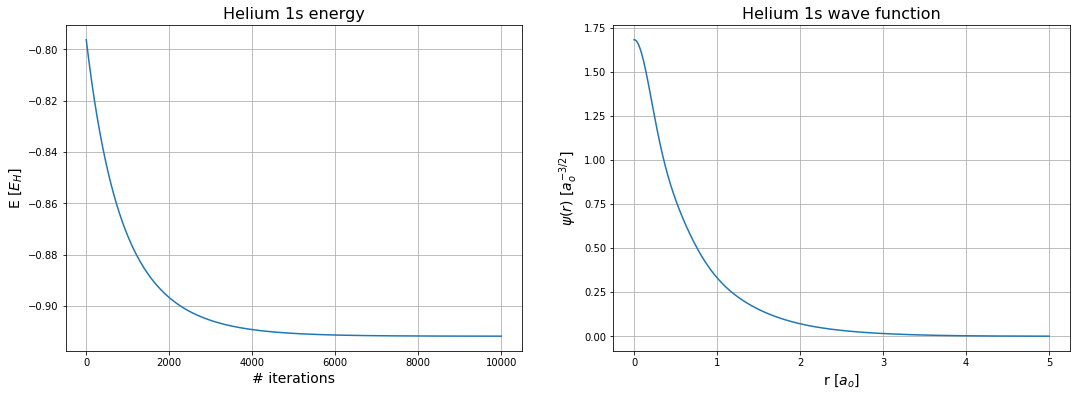

<IPython.core.display.Latex object>

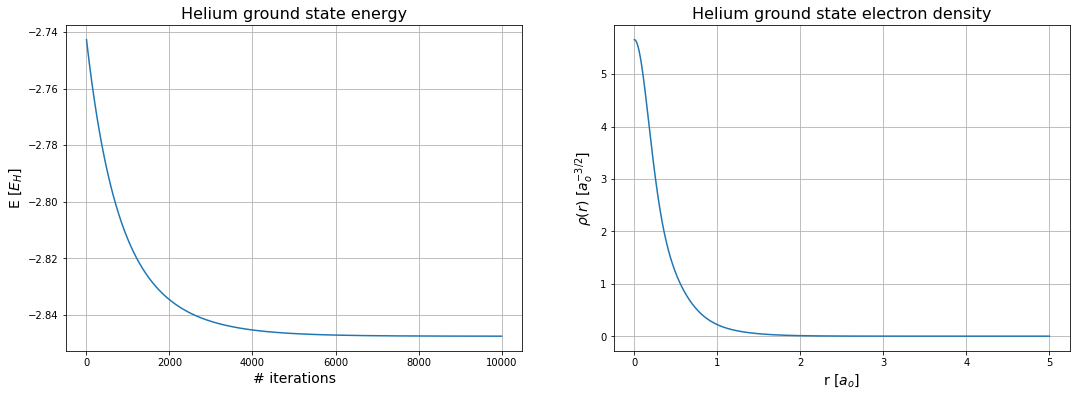

In [5]:
pdf = PdfPages('He.pdf')

f = lambda x, a, b, c: a * np.exp(- b * x) + c

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)], E[:, 0], p0=[0.2, 1e-3, -0.9])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_{{1s}} = {popt[2]:.5f} \pm {perr[2]:.5f}$'))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 0])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Helium 1s energy', fontsize=16)
plt.grid()

wf_He = np.zeros(1000)
for q in range(4):
    wf_He += g_norm(q) * np.exp(-alpha_He[q] * rgrid**2) * C[q, 0]

wf_He = wf_He / np.sqrt(simpson(wf_He**2, rgrid))
C[:, 0] = C[:, 0] / np.sqrt(simpson(wf_He**2, rgrid))

plt.subplot(122)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Helium 1s wave function', fontsize=16)
plt.plot(rgrid, -wf_He)
plt.grid()
pdf.savefig()
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 1])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Helium ground state energy', fontsize=16)
plt.grid()

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)], E[:, 1], p0=[0.2, 1e-3, -2])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_0 = {popt[2]:.5f} \pm {perr[2]:.5f}$'))

plt.subplot(122)
plt.plot(rgrid, 2 * wf_He**2)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\rho(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Helium ground state electron density', fontsize=16)
plt.grid()
pdf.savefig()
plt.show()

pdf.close()

# 4. Beryllium

In [6]:
alpha_Be1s = [0.7064859542e2, 0.1292782254e2, 0.3591490662e1, 0.1191983464e1]
alpha_Be2s = [0.3072833610e1, 0.6652025433,   0.2162825386,   0.8306680972e-1]

alpha_Be = np.array(alpha_Be1s + alpha_Be2s)

d_1s = [0.5675242080E-01,  0.2601413550E+00, 0.5328461143E+00, 0.2916254405E+00]
d_2s = [-0.6220714565E-01, 0.2976804596E-04, 0.5588549221E+00, 0.4977673218E+00]

d_Be = np.array(d_1s + d_2s)

## Without contractions

In [7]:
Z = 4

start = time.time()

def g_norm(*args):
    norm = 1
    for arg in args:
        norm *= (2 * alpha_Be[arg] / np.pi)**(0.75)
    return norm

# compute integral values beforehand
direct   = np.zeros((8, 8, 8, 8))
exchange = np.zeros((8, 8, 8, 8))
for p, q, r, s in product(range(8), repeat=4):
    alpha = alpha_Be[p] + alpha_Be[q]
    beta  = alpha_Be[r] + alpha_Be[s]

    direct[p, q, r, s] = g_norm(p, q, r, s) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)

    alpha = alpha_Be[p] + alpha_Be[s]
    beta  = alpha_Be[q] + alpha_Be[r]

    exchange[p, q, r, s] = g_norm(p, q, r, s) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)


##### STEP 0 #####
h = np.zeros((8, 8))
S = np.zeros((8, 8))

for p, q in product(range(8), repeat=2):
    # kinetic part
    h[p, q] = g_norm(p, q) * 3*np.pi**(1.5) * alpha_Be[p] * alpha_Be[q]
    h[p, q] /= (alpha_Be[p] + alpha_Be[q])**(2.5)
    
    # external potential part
    h[p, q] -= g_norm(p, q) * Z * 2*np.pi / (alpha_Be[p] + alpha_Be[q])
    
    # overlap matrix
    S[p, q] = g_norm(p, q) * (np.pi / (alpha_Be[p] + alpha_Be[q]))**(1.5)

e, C = eigh(h, S)


##### SCF ######
N = 10000

E = np.zeros((N, 3))
for n in range(N):
    J = np.zeros((8, 8))
    K = np.zeros((8, 8))

    for p, q, r, s in product(range(8), repeat=4):
        rho = C[r, 0] * C[s, 0] + C[r, 1] * C[s, 1]

        # direct term
        J[p, q] += rho * direct[p, q, r, s]

        # exchange term
        K[p, q] += rho * exchange[p, q, r, s]

    F = h + 2*J - K
    e, Cex = eigh(F, S)
    
    Etot = e[0] + e[1]
    for r, s in product(range(8), repeat=2):
        Etot += (Cex[r, 0] * Cex[s, 0] + Cex[r, 1] * Cex[s, 1]) * h[r, s]

    E[n] = (e[0], e[1], Etot)

    C = eta*Cex + (1 - eta)*C
    
C_nc = C[:, :2]
print(f'Durations {(time.time() - start):.2f} s')

Durations 133.48 s


<IPython.core.display.Latex object>

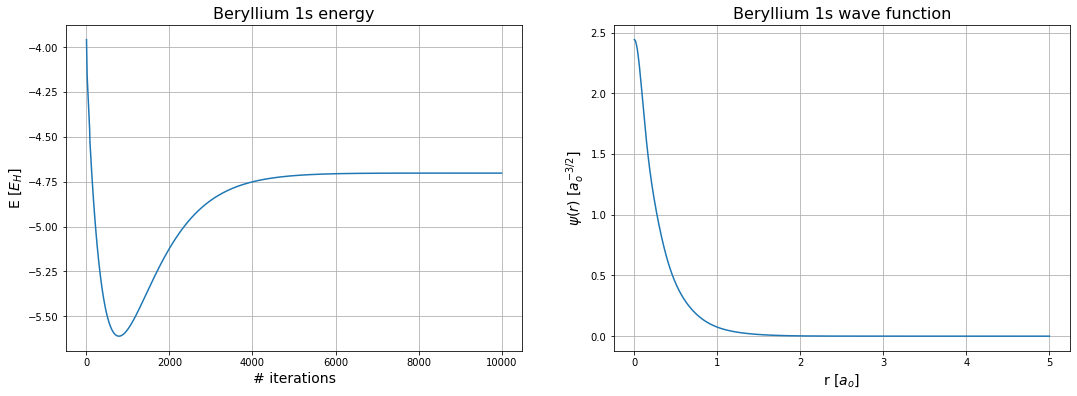

<IPython.core.display.Latex object>

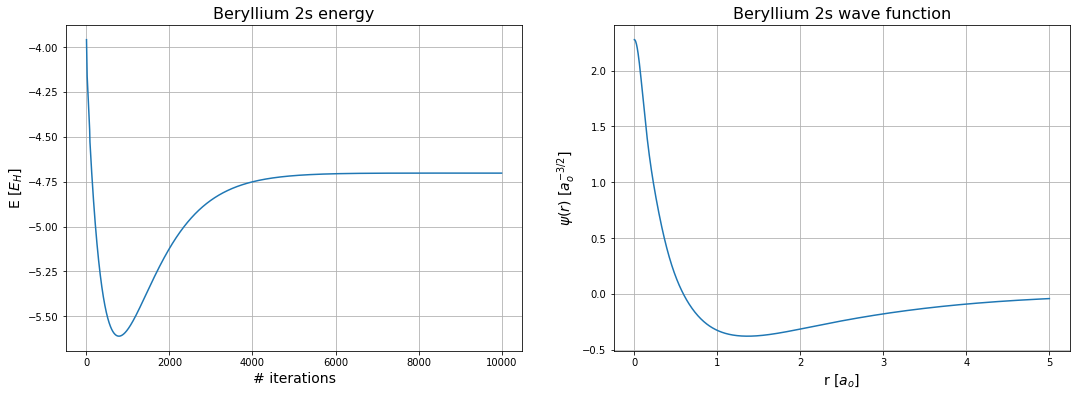

<IPython.core.display.Latex object>

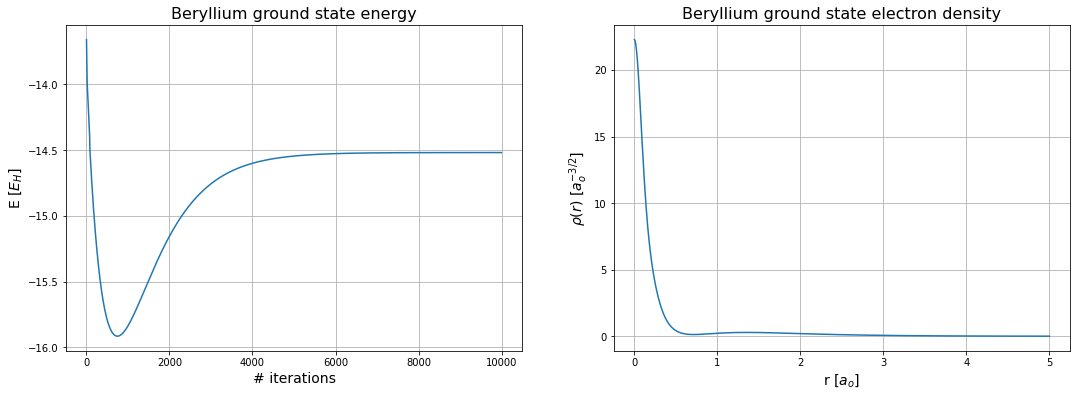

In [8]:
pdf = PdfPages('Be_nc.pdf')
##### 1s #####

f = lambda x, a, b, c: a * np.exp(- b * x) + c

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 0], p0=[0.2, 1e-3, -4.5])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_{{1s}} = {popt[2]:.5f} \pm {perr[2]:.5f}$'))

# plot solution
wf_1s = np.zeros(1000)
for q in range(8):
    wf_1s += g_norm(q) * np.exp(-alpha_Be[q] * rgrid**2) * C[q, 0]
    
wf_1s = wf_1s / np.sqrt(simpson(wf_1s**2, rgrid))
C_nc[:, 0] = C_nc[:, 0] / np.sqrt(simpson(wf_1s**2, rgrid))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 0])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium 1s energy', fontsize=16)
plt.grid()

plt.subplot(122)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium 1s wave function', fontsize=16)
plt.plot(rgrid, wf_1s)
plt.grid()
pdf.savefig()
plt.show()

##### 2s #####

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 1], p0=[0.2, 1e-3, -0.3])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_{{2s}} = {popt[2]:.5f} \pm {perr[2]:.5f}$'))

wf_2s = np.zeros(1000)
for q in range(8):
    wf_2s += g_norm(q) * np.exp(-alpha_Be[q] * rgrid**2) * C[q, 1]
    
wf_2s = wf_2s / np.sqrt(simpson(wf_2s**2, rgrid))
C_nc[:, 1] = C_nc[:, 1] / np.sqrt(simpson(wf_2s**2, rgrid))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 0])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium 2s energy', fontsize=16)
plt.grid()

plt.subplot(122)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium 2s wave function', fontsize=16)
plt.plot(rgrid, wf_2s)
plt.grid()
pdf.savefig()
plt.show()

##### Ground state #####

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 2], p0=[0.2, 1e-3, -14])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_0 = {popt[2]:.5f} \pm {perr[2]:.5f}$'))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 2])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium ground state energy', fontsize=16)
plt.grid()

rho = 2 * (wf_1s**2 + wf_2s**2)
rho = rho * 4 / simpson(rho, rgrid)

plt.subplot(122)
plt.plot(rgrid, rho)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\rho(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium ground state electron density', fontsize=16)
plt.grid()
pdf.savefig()
plt.show()

pdf.close()

In [9]:
print(C_nc)

[[ 0.06118629  0.0115063 ]
 [ 0.26326887  0.05182096]
 [ 0.50056727  0.15545032]
 [ 0.32390783  0.20357735]
 [-0.0035583  -0.04294387]
 [-0.0021149  -0.07348299]
 [ 0.0149041  -0.25079572]
 [-0.00409363 -0.81064266]]


## With contractions

In [10]:
Z = 4

start = time.time()

alpha_Be = np.array(alpha_Be1s + alpha_Be2s)

def g_norm(*args):
    norm = 1
    for arg in args:
        norm *= (2 * alpha_Be[arg] / np.pi)**(0.75)
    return norm

# compute integral values beforehand
direct   = np.zeros((2, 2, 2, 2))
exchange = np.zeros((2, 2, 2, 2))
for p, q, r, s in product(range(2), repeat=4):
    for a, b, c, d in product(range(4), repeat=4):
        # variable change in order to mantain one index
        a = a + 4*p
        b = b + 4*q
        c = c + 4*r
        d = d + 4*s
        
        # contractions coefficients product
        D = d_Be[a] * d_Be[b] * d_Be[c] * d_Be[d]
        
        alpha = alpha_Be[a] + alpha_Be[b]
        beta  = alpha_Be[c] + alpha_Be[d]

        direct[p, q, r, s] += D * g_norm(a, b, c, d) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)

        alpha = alpha_Be[a] + alpha_Be[d]
        beta  = alpha_Be[b] + alpha_Be[c]

        exchange[p, q, r, s] += D * g_norm(a, b, c, d) * 2*np.pi**(2.5) / alpha / beta / np.sqrt(alpha + beta)

##### STEP 0 #####
h = np.zeros((2, 2))
S = np.zeros((2, 2))

for p, q in product(range(2), repeat=2):
    for a, b in product(range(4), repeat=2):
        # variable change in order to mantain one index
        a = a + 4*p
        b = b + 4*q
        
        # contractions coefficients product
        D = d_Be[a] * d_Be[b]

        # kinetic part
        h[p, q] += D * g_norm(a, b) * 3*np.pi**(1.5) * alpha_Be[a]*alpha_Be[b]/(alpha_Be[a]+alpha_Be[b])**(2.5)

        # external potential part
        h[p, q] -= D * g_norm(a, b) * Z * 2*np.pi / (alpha_Be[a] + alpha_Be[b])

        # overlap matrix
        S[p, q] += D * g_norm(a, b) * (np.pi / (alpha_Be[a] + alpha_Be[b]))**(1.5)

e, C = eigh(h, S)


##### SCF ######
N = 10000

E = np.zeros((N, 3))
for n in range(N):
    J = np.zeros((2, 2))
    K = np.zeros((2, 2))

    for p, q, r, s in product(range(2), repeat=4):
        rho = C[r, 0] * C[s, 0] + C[r, 1] * C[s, 1]

        # direct term
        J[p, q] += rho * direct[p, q, r, s]

        # exchange term
        K[p, q] += rho * exchange[p, q, r, s]

    F = h + 2*J - K
    e, Cex = eigh(F, S)
    
    Etot = e[0] + e[1]
    for r, s in product(range(2), repeat=2):
        Etot += (Cex[r, 0] * Cex[s, 0] + Cex[r, 1] * Cex[s, 1]) * h[r, s]

    E[n] = (e[0], e[1], Etot)

    C = eta*Cex + (1 - eta)*C
    
C_wc = C[:, :]
C_wc[:, 0] /= np.sqrt(np.sum(C_wc[:, 0]**2))
C_wc[:, 1] /= np.sqrt(np.sum(C_wc[:, 1]**2))

print(f'Durations {(time.time() - start):.2f} s')

Durations 1.20 s


<IPython.core.display.Latex object>

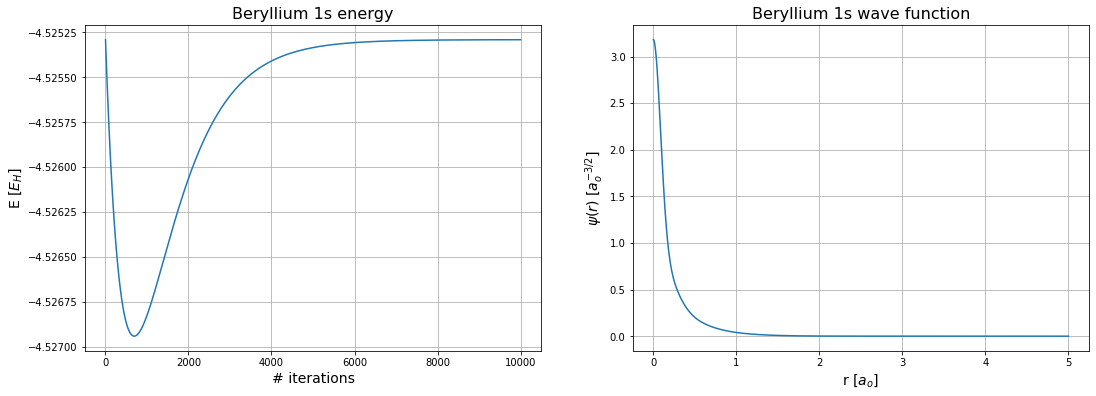

<IPython.core.display.Latex object>

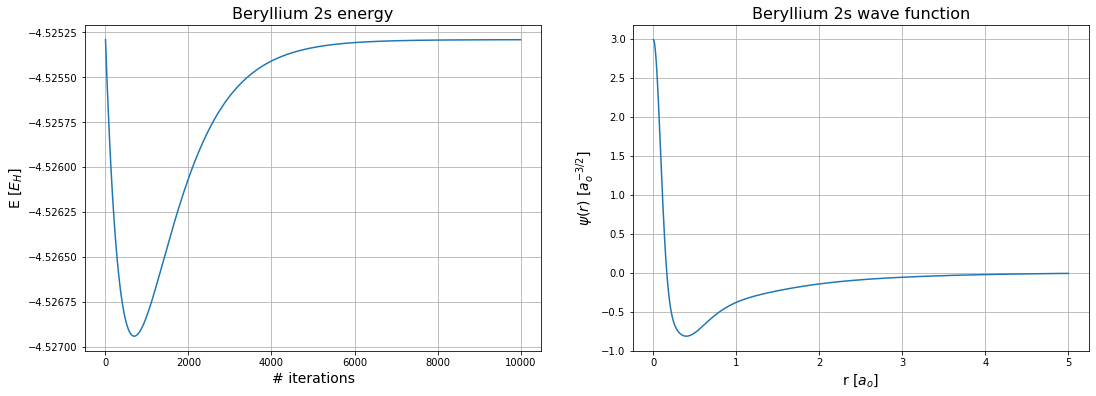

<IPython.core.display.Latex object>

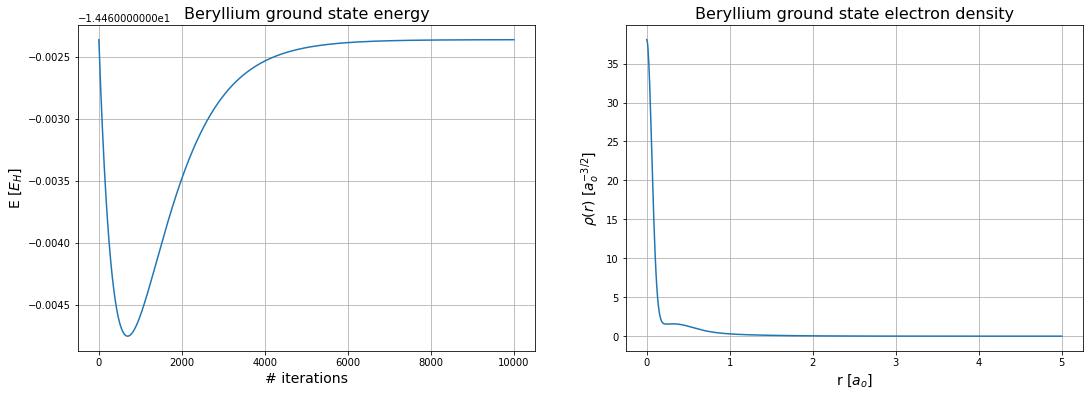

In [11]:
pdf = PdfPages('Be_wc.pdf')

##### 1s #####

f = lambda x, a, b, c: a * np.exp(- b * x) + c

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 0], p0=[0.2, 1e-3, -4.5])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_{{1s}} = {popt[2]:.8f} \pm {perr[2]:.8f}$'))

# plot solution
wf_1s = np.zeros(1000)
for r, a in product(range(2), range(4)):
    wf_1s += g_norm(a + 4*r) * np.exp(-alpha_Be[a + 4*r] * rgrid**2) * C[r, 0]
wf_1s = wf_1s / np.sqrt(simpson(wf_1s**2, rgrid))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 0])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium 1s energy', fontsize=16)
plt.grid()

plt.subplot(122)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium 1s wave function', fontsize=16)
plt.plot(rgrid, -wf_1s)
plt.grid()
pdf.savefig()
plt.show()

##### 2s #####

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 1], p0=[0.2, 1e-3, -0.3])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_{{2s}} = {popt[2]:.8f} \pm {perr[2]:.8f}$'))

wf_2s = np.zeros(1000)
for r, a in product(range(2), range(4)):
    wf_2s += g_norm(a + 4*r) * np.exp(-alpha_Be[a + 4*r] * rgrid**2) * C[r, 1]
wf_2s = wf_2s / np.sqrt(simpson(wf_2s**2, rgrid))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 0])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium 2s energy', fontsize=16)
plt.grid()

plt.subplot(122)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\psi(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium 2s wave function', fontsize=16)
plt.plot(rgrid, wf_2s)
plt.grid()
pdf.savefig()
plt.show()

##### Ground state #####

popt, pcov = curve_fit(f, [i+1 / N for i in range(N)][2000:], E[2000:, 2], p0=[0.2, 1e-3, -14])
perr = np.sqrt(np.diag(pcov))

display(Latex(f'$E_0 = {popt[2]:.7f} \pm {perr[2]:.7f}$'))

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.plot([i+1 for i in range(N)], E[:, 2])
plt.xlabel('# iterations', fontsize=14)
plt.ylabel('E [$E_H$]', fontsize=14)
plt.title(f'Beryllium ground state energy', fontsize=16)
plt.grid()

rho = 2 * (wf_1s**2 + wf_2s**2)
rho = rho * 4 / simpson(rho, rgrid)

plt.subplot(122)
plt.plot(rgrid, rho)
plt.xlabel('r [$a_o$]', fontsize=14)
plt.ylabel('$\\rho(r)$ [$a_o^{-3/2}$]', fontsize=14)
plt.title(f'Beryllium ground state electron density', fontsize=16)
plt.grid()
pdf.savefig()
plt.show()

pdf.close()

In [12]:
print(C_wc)

[[-0.99979833  0.26385774]
 [-0.02008253 -0.96456161]]
